# Estimating Critical Multi-Task Batch Sizes from Gradient Noise Scale

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from gns_utils import split_dataframe, csv_log_to_dataframe

In [2]:
pd.options.mode.chained_assignment = None
DATA_DIR = Path("3_time_intervals/results")
VIS_DIR = Path("4_critical_batches")

In [3]:
data = pd.concat(
    [csv_log_to_dataframe(DATA_DIR / file) 
    for file in os.listdir(DATA_DIR) if ".csv" in file],
    ignore_index=True
)
metadata, params, results = split_dataframe(data)
data["model"] = data["model"].apply(lambda x: int(x.strip(".pt")))
data = data.rename(columns={"model": "training_step"})

metadata

,date,runtime (s),user,host,ckpt_dir,vis_dir,save_fig,accumulate,epoch,verbose,no_seed,no_warnings
0,2025-01-31 16:59:29,269.954519,cimsir,diorit.cip.ifi.lmu.de,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,True,False,False,False,True
1,2025-01-31 17:12:14,269.936655,cimsir,diamiktit.cip.ifi.lmu.de,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,True,False,False,False,True
2,2025-01-31 17:36:09,268.755545,cimsir,diorit.cip.ifi.lmu.de,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,True,False,False,False,True
3,2025-01-31 17:45:18,267.178063,cimsir,diorit.cip.ifi.lmu.de,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,True,False,False,False,True
4,2025-01-31 17:49:51,268.653490,cimsir,diorit.cip.ifi.lmu.de,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
250,2025-01-31 11:43:51,274.328680,cimsir,basalt.cip.ifi.lmu.de,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,True,False,False,False,True
251,2025-01-31 11:45:42,299.964664,cimsir,arkose.cip.ifi.lmu.de,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,True,False,False,False,True
252,2025-01-31 11:50:48,300.777975,cimsir,arkose.cip.ifi.lmu.de,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,True,False,False,False,True
253,2025-01-31 11:57:57,272.741052,cimsir,basalt.cip.ifi.lmu.de,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,True,False,False,False,True


In [4]:
data

,training_step,true_portion,diff_steps,B,b,reps,t_min,t_max,accumulate,epoch,...,ckpt_dir,vis_dir,save_fig,date,gns_est,g_norm,b_true,runtime (s),user,host
0,90000,0.1,1000,5000,50,2,201,300,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 16:59:29,8000.609863,0.023219,5000,269.954519,cimsir,diorit.cip.ifi.lmu.de
1,90000,0.1,1000,5000,50,2,201,300,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 17:12:14,4375.177246,0.023826,5000,269.936655,cimsir,diamiktit.cip.ifi.lmu.de
2,80000,0.1,1000,5000,50,2,0,100,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 17:36:09,10358.764648,0.026551,5000,268.755545,cimsir,diorit.cip.ifi.lmu.de
3,80000,0.1,1000,5000,50,2,201,300,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 17:45:18,544.148010,0.027077,5000,267.178063,cimsir,diorit.cip.ifi.lmu.de
4,80000,0.1,1000,5000,50,2,301,400,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 17:49:51,539.492859,0.022269,5000,268.653490,cimsir,diorit.cip.ifi.lmu.de
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,80000,0.1,1000,5000,50,2,901,1000,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 11:43:51,8.516977,0.013595,5000,274.328680,cimsir,basalt.cip.ifi.lmu.de
251,80000,0.1,1000,5000,50,2,801,900,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 11:45:42,12.934482,0.014062,5000,299.964664,cimsir,arkose.cip.ifi.lmu.de
252,80000,0.1,1000,5000,50,2,901,1000,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 11:50:48,9.293446,0.013586,5000,300.777975,cimsir,arkose.cip.ifi.lmu.de
253,90000,0.1,1000,5000,50,2,201,300,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 11:57:57,1225.715454,0.020759,5000,272.741052,cimsir,basalt.cip.ifi.lmu.de


#### Normalization Functions

In [5]:
def p1_normalize(gns: iter):
    return (np.asarray(gns) / np.linalg.norm(gns , ord=1)) * 50_000

def softmax_normalize(gns: iter, T=1):
    assert T != 0
    gns = torch.tensor(np.asarray(gns) / T)
    return np.asarray(torch.nn.functional.softmax(gns, dim=0) * 50_000)

#### Batch Size Estimation

In [6]:
def estimate_critical_batch_size_from_time_bins(data: pd.DataFrame, normalize: callable, **T):
    ## Get gns values on intervals
    df_list = []
    for model in sorted(set(data["training_step"])):
        df = data[data["training_step"] == model].sort_values("t_min")
        df = df[["training_step", "t_min", "t_max", "gns_est"]]
        df = df.groupby(["training_step", "t_min", "t_max"]).mean().reset_index()
        
        ## Assuming no missing values (complete intervals) !
        if len(df) == 10:
            df_list.append(df)
        
    for df in df_list:
        gns = df["gns_est"]
        gns = torch.tensor(np.array(gns))
        
        ## Calculate batch size
        batch_sizes = normalize(gns, **T)
        df["batch_size"] = batch_sizes
        df["batch_size"] = df["batch_size"].astype(int)
        
    return df_list

In [7]:
def visualize_batches_over_training_steps(df_list, 
                                          title="Critical Batch Sizes over Training Steps",
                                          save_fig=None):
    num_batches = len(df_list)
    fig, axes = plt.subplots(2, num_batches, figsize=(max(12, num_batches * 5), 10))  
    fig.suptitle(title, fontsize=20, fontweight="bold")

    for i, df in enumerate(df_list):
        model = df.set_index(["t_min", "t_max"])
        training_step = df["training_step"].iloc[0]
        
        ax1 = axes[0, i]
        model["batch_size"].plot.bar(ax=ax1, color="steelblue", alpha=0.8)
        ax1.set_title(f"Step {training_step}", fontsize=16)
        ax1.set_xticklabels([])
        ax1.set_xlabel("")
        if i == 0:
            ax1.set_ylabel("Batch Size", fontsize=14)
        ax1.grid(axis="y", linestyle="--", alpha=0.5)

        ax2 = axes[1, i]
        model["gns_est"].plot(ax=ax2, color="darkred", linewidth=2)
        ax2.set_xlabel("Time Range", fontsize=12)
        if i == 0:
            ax2.set_ylabel("Gradient Noise Scale", fontsize=14)
        ax2.grid(axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    if save_fig:
        plt.savefig(save_fig, dpi=300, bbox_inches="tight")

    plt.show()

## Estimate with P1-Norm

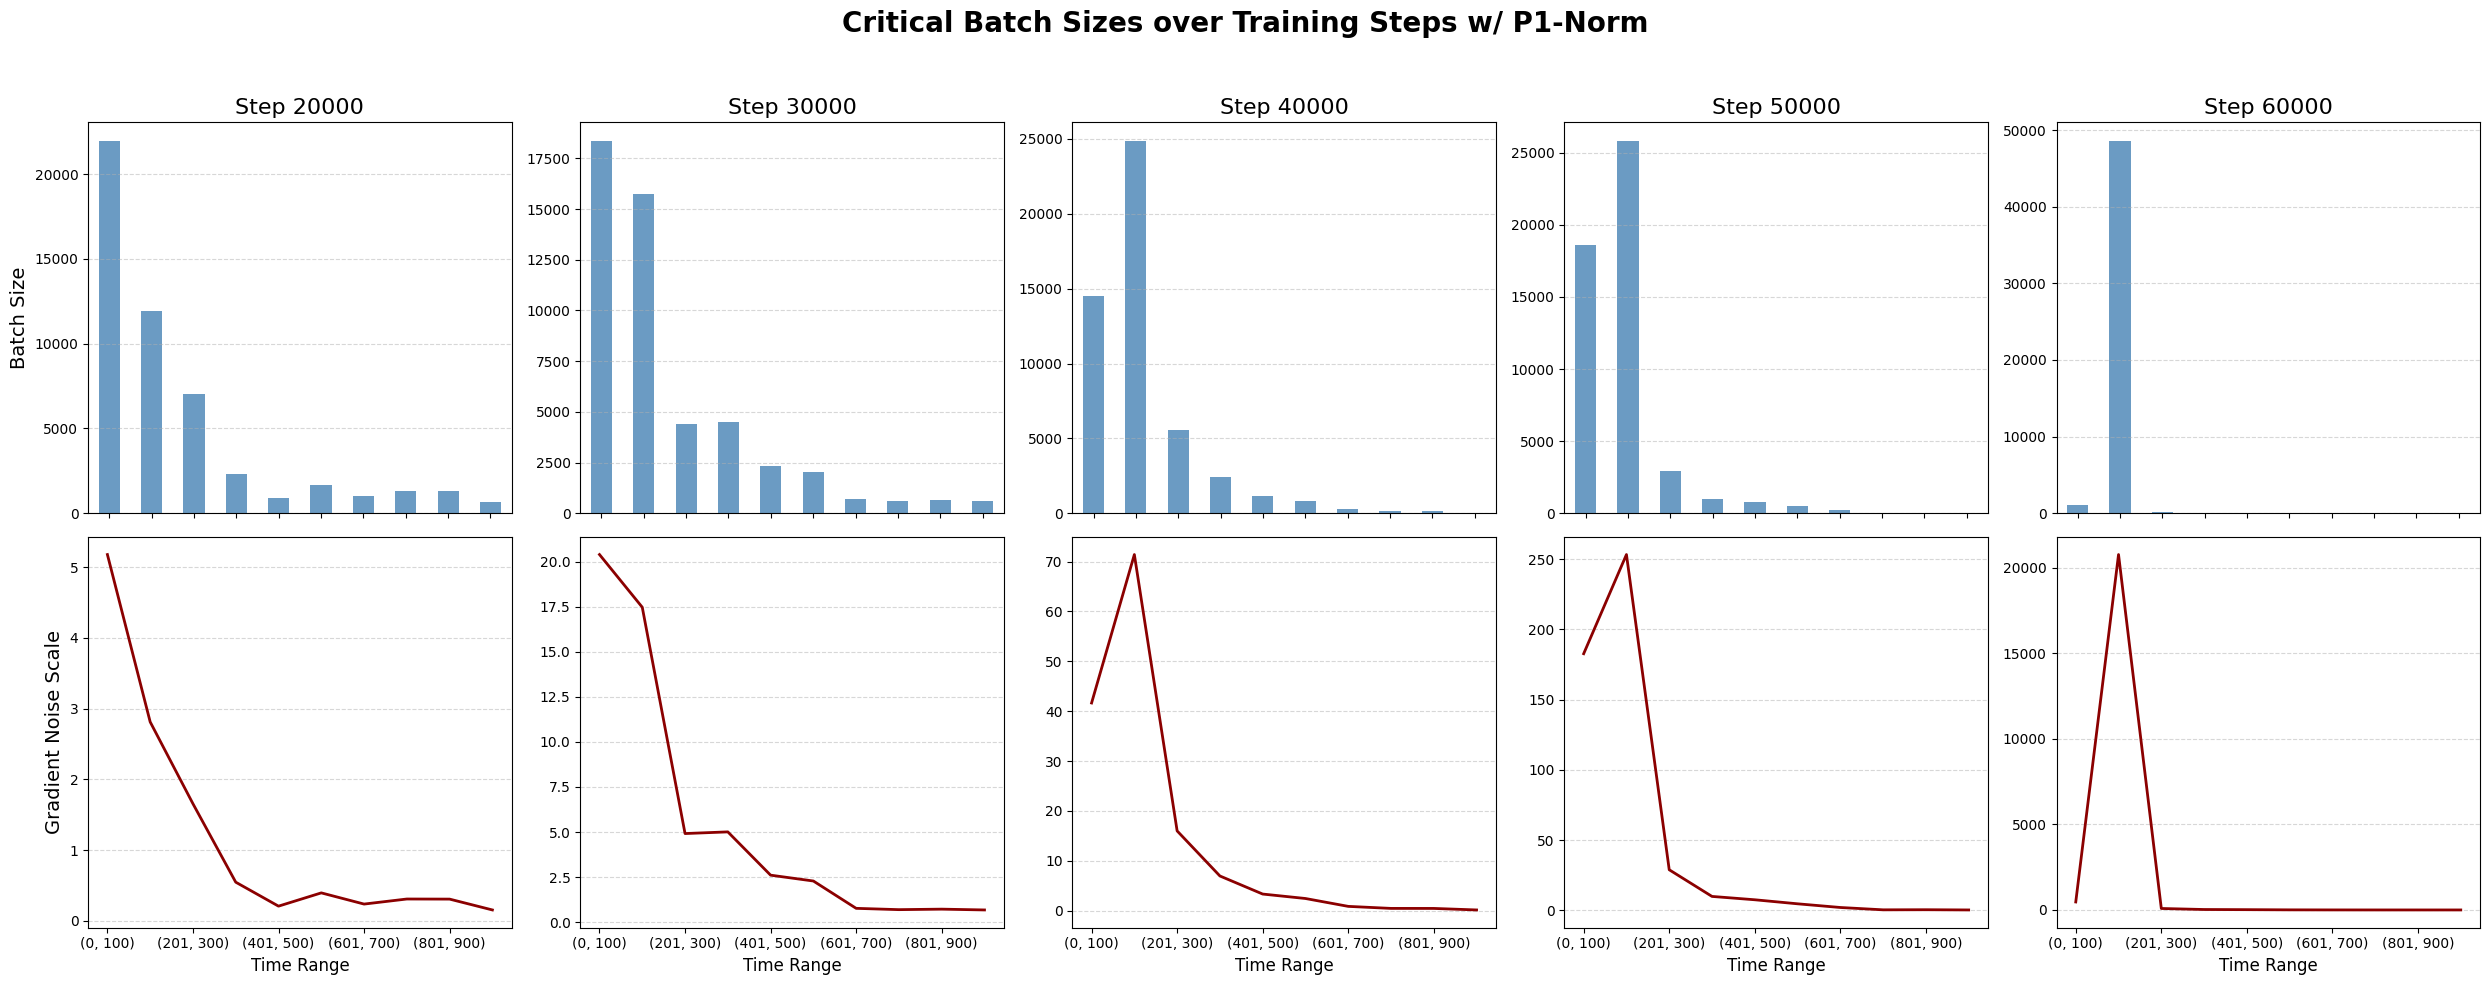

In [8]:
p1_batches = estimate_critical_batch_size_from_time_bins(data, normalize=p1_normalize)
title = "Critical Batch Sizes over Training Steps" + " w/ P1-Norm"
save_fig =  VIS_DIR / f"critical_batch_sizes_p1_norm.png"
visualize_batches_over_training_steps(p1_batches, title=title, save_fig=save_fig)

## Estimate using Softmax with Temperature

Softmax with T=1:

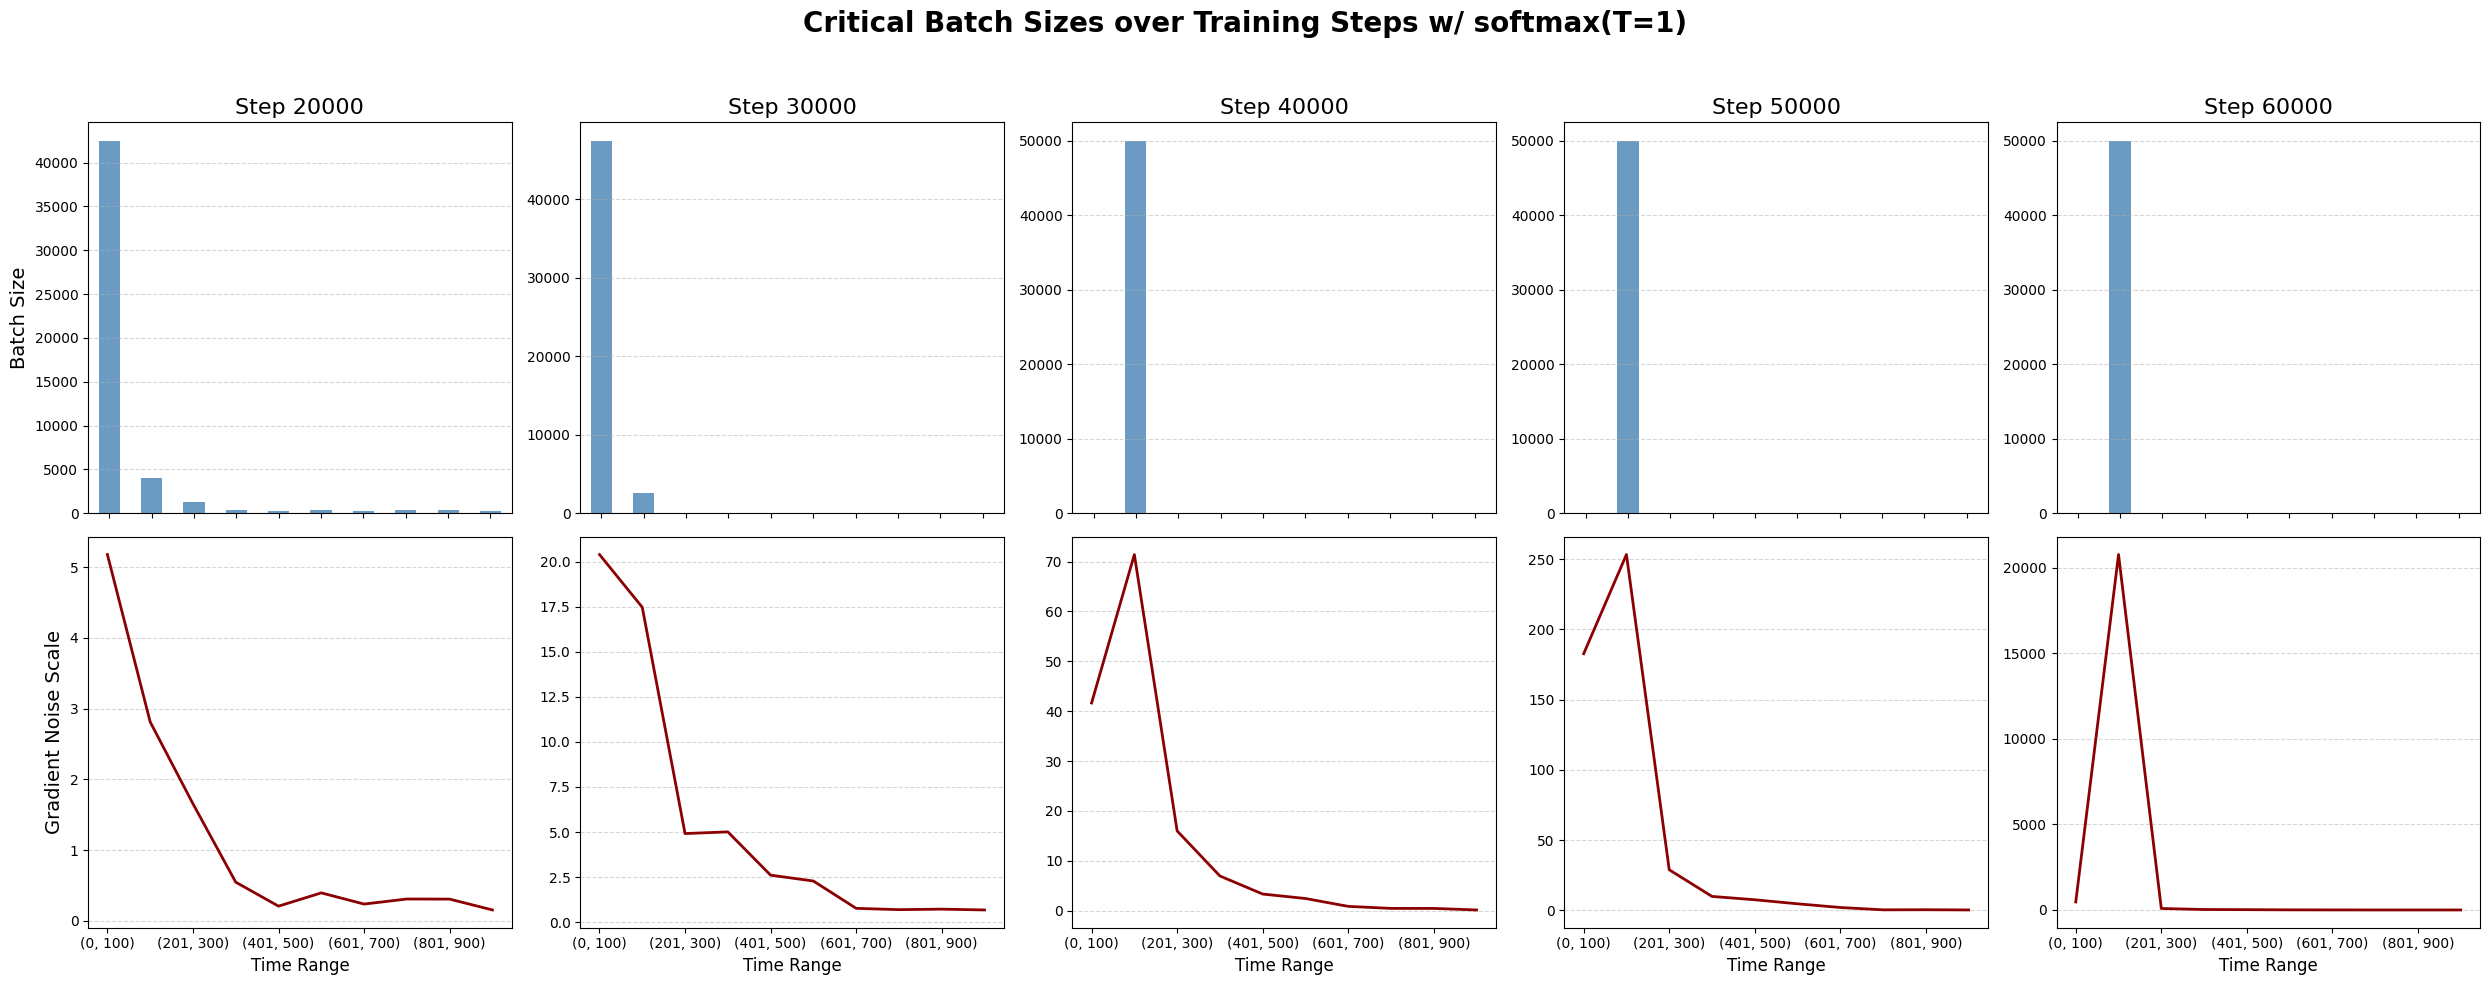

In [9]:
softmax_batches1 = estimate_critical_batch_size_from_time_bins(data, normalize=softmax_normalize, T=1)
title = "Critical Batch Sizes over Training Steps" + f" w/ softmax(T={1})"
save_fig =  VIS_DIR / f"critical_batch_sizes_softmax_T{1}_norm.png"
visualize_batches_over_training_steps(softmax_batches1, title=title, save_fig=save_fig)

Softmax with T=2:

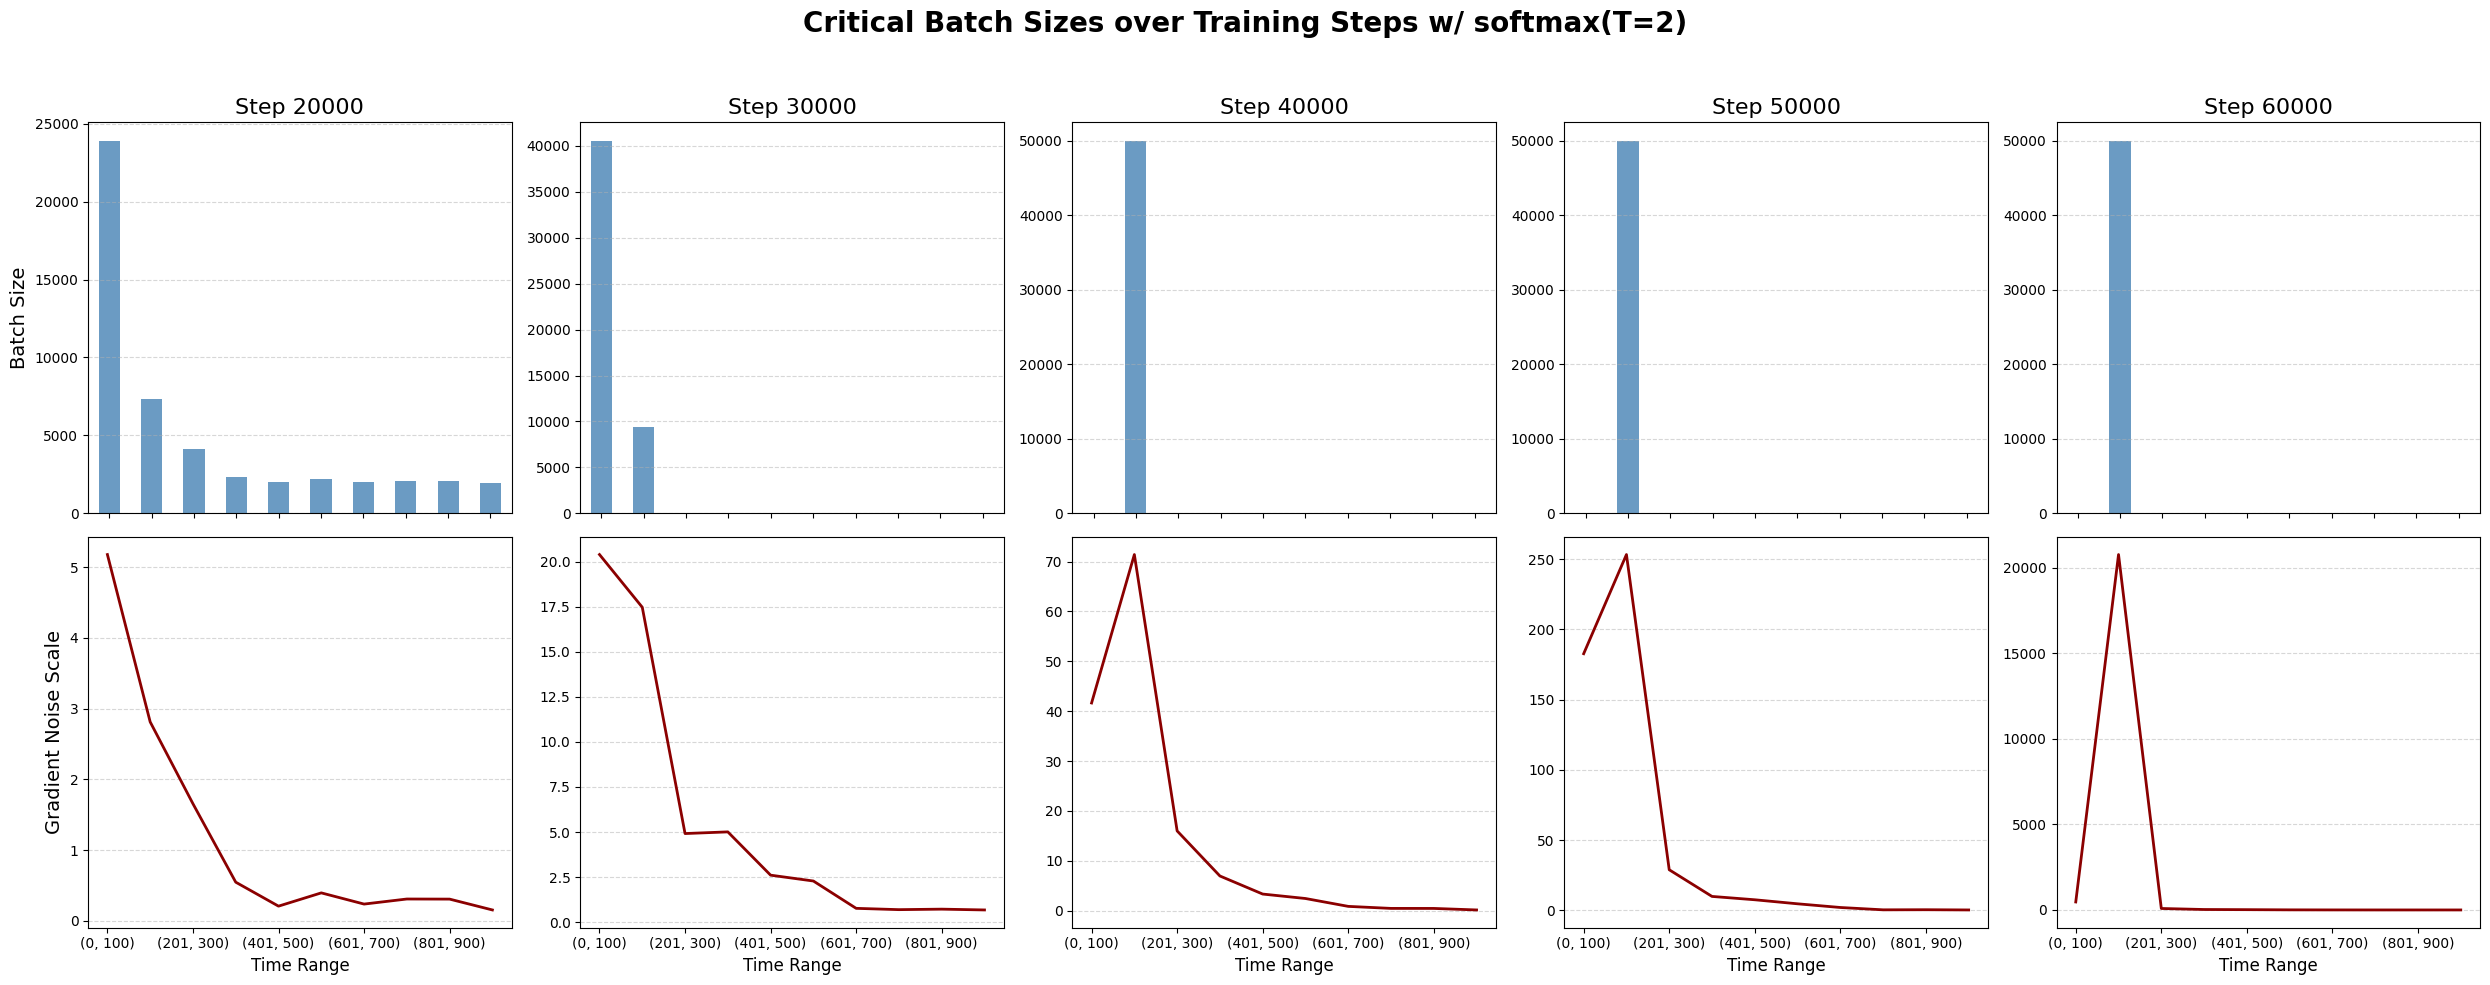

In [10]:
softmax_batches2 = estimate_critical_batch_size_from_time_bins(data, normalize=softmax_normalize, T=2)
title = "Critical Batch Sizes over Training Steps" + f" w/ softmax(T={2})"
save_fig =  VIS_DIR / f"critical_batch_sizes_softmax_T{2}_norm.png"
visualize_batches_over_training_steps(softmax_batches2, title=title, save_fig=save_fig)

Softmax with T=5:

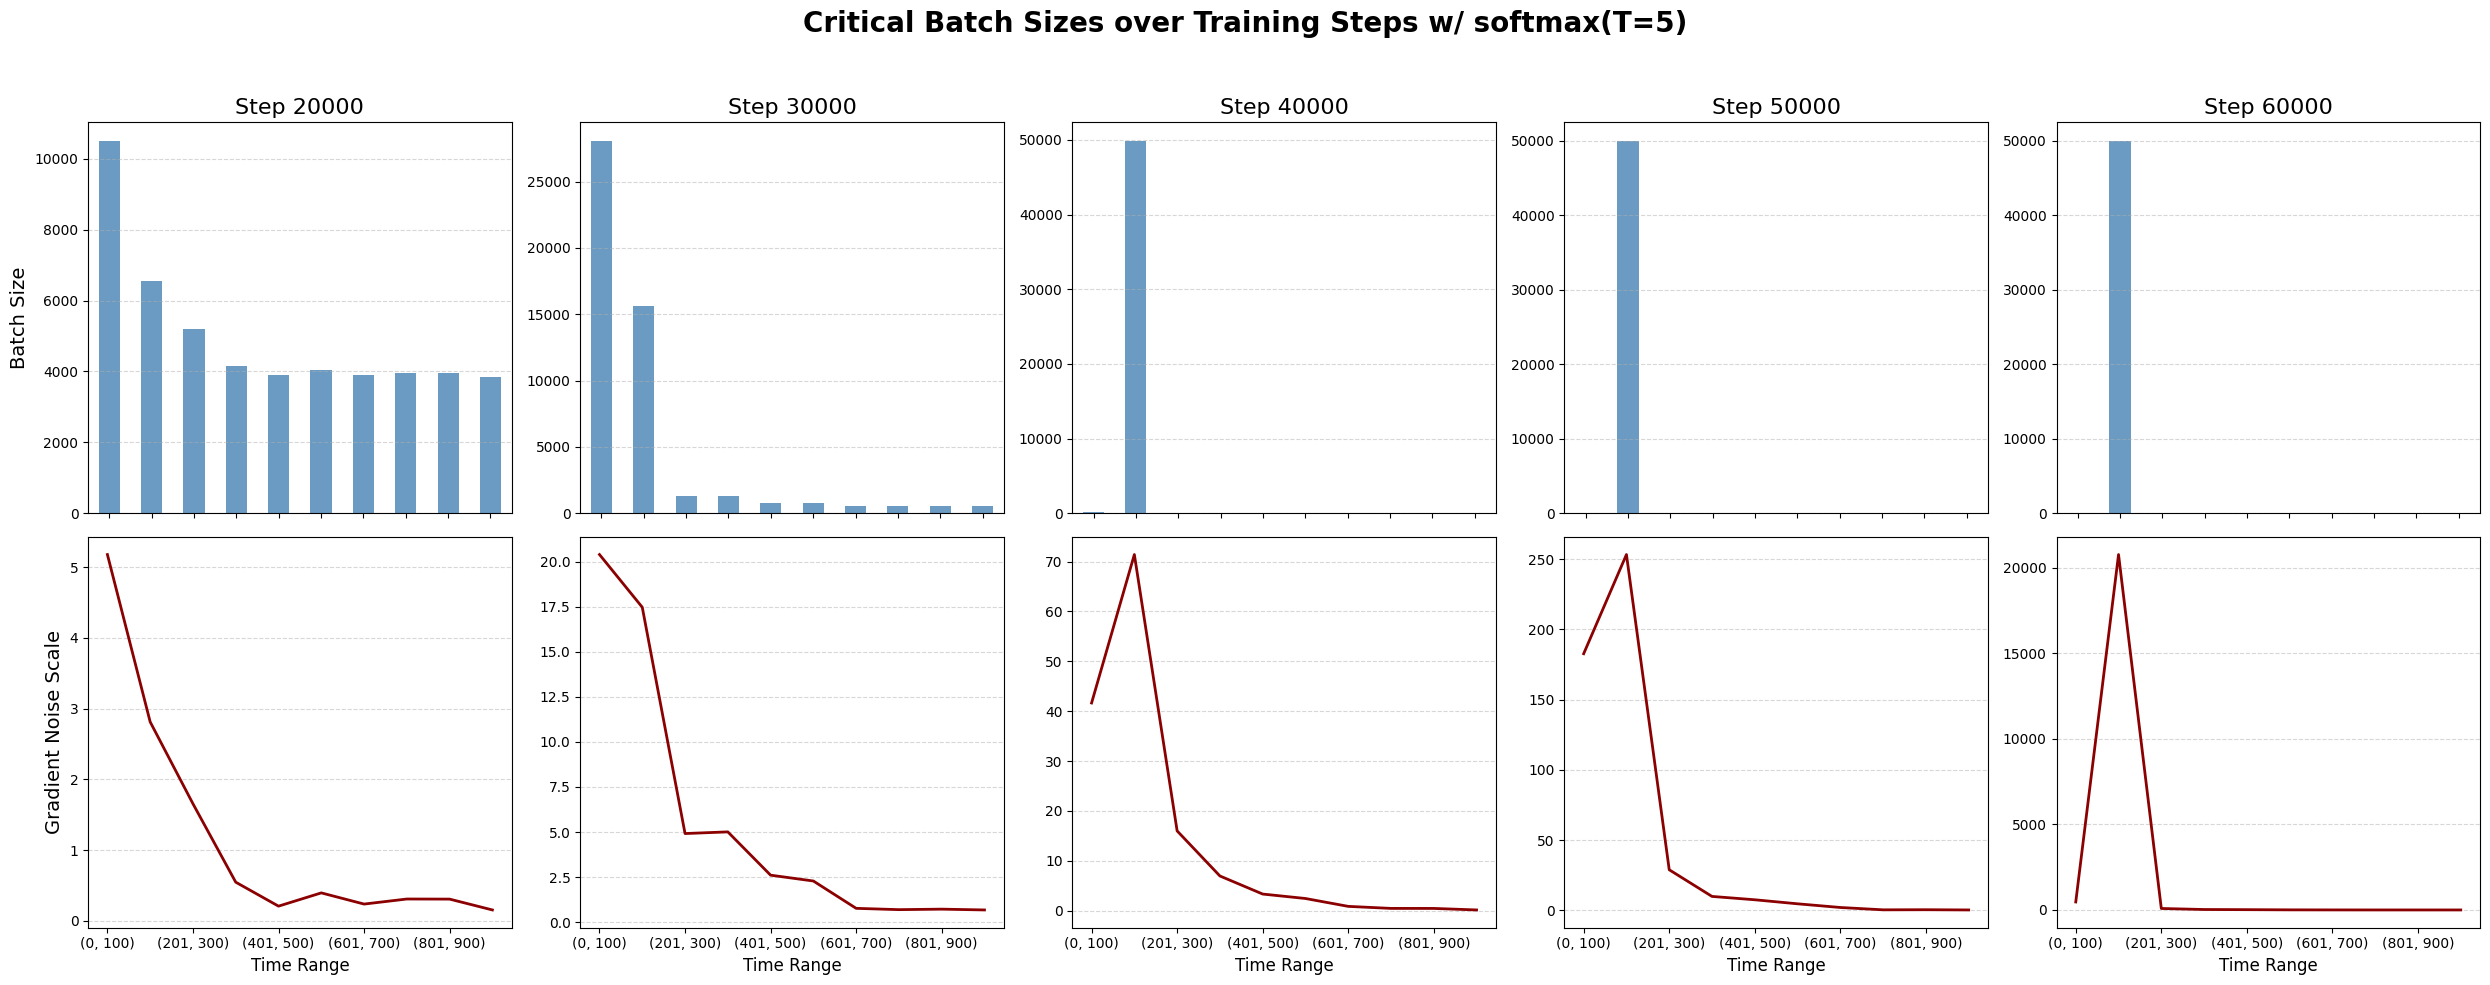

In [11]:
softmax_batches5 = estimate_critical_batch_size_from_time_bins(data, normalize=softmax_normalize, T=5)
title = "Critical Batch Sizes over Training Steps" + f" w/ softmax(T={5})"
save_fig = VIS_DIR / f"critical_batch_sizes_softmax_T{5}_norm.png"
visualize_batches_over_training_steps(softmax_batches5, title=title, save_fig=save_fig)

Softmax with T=10:

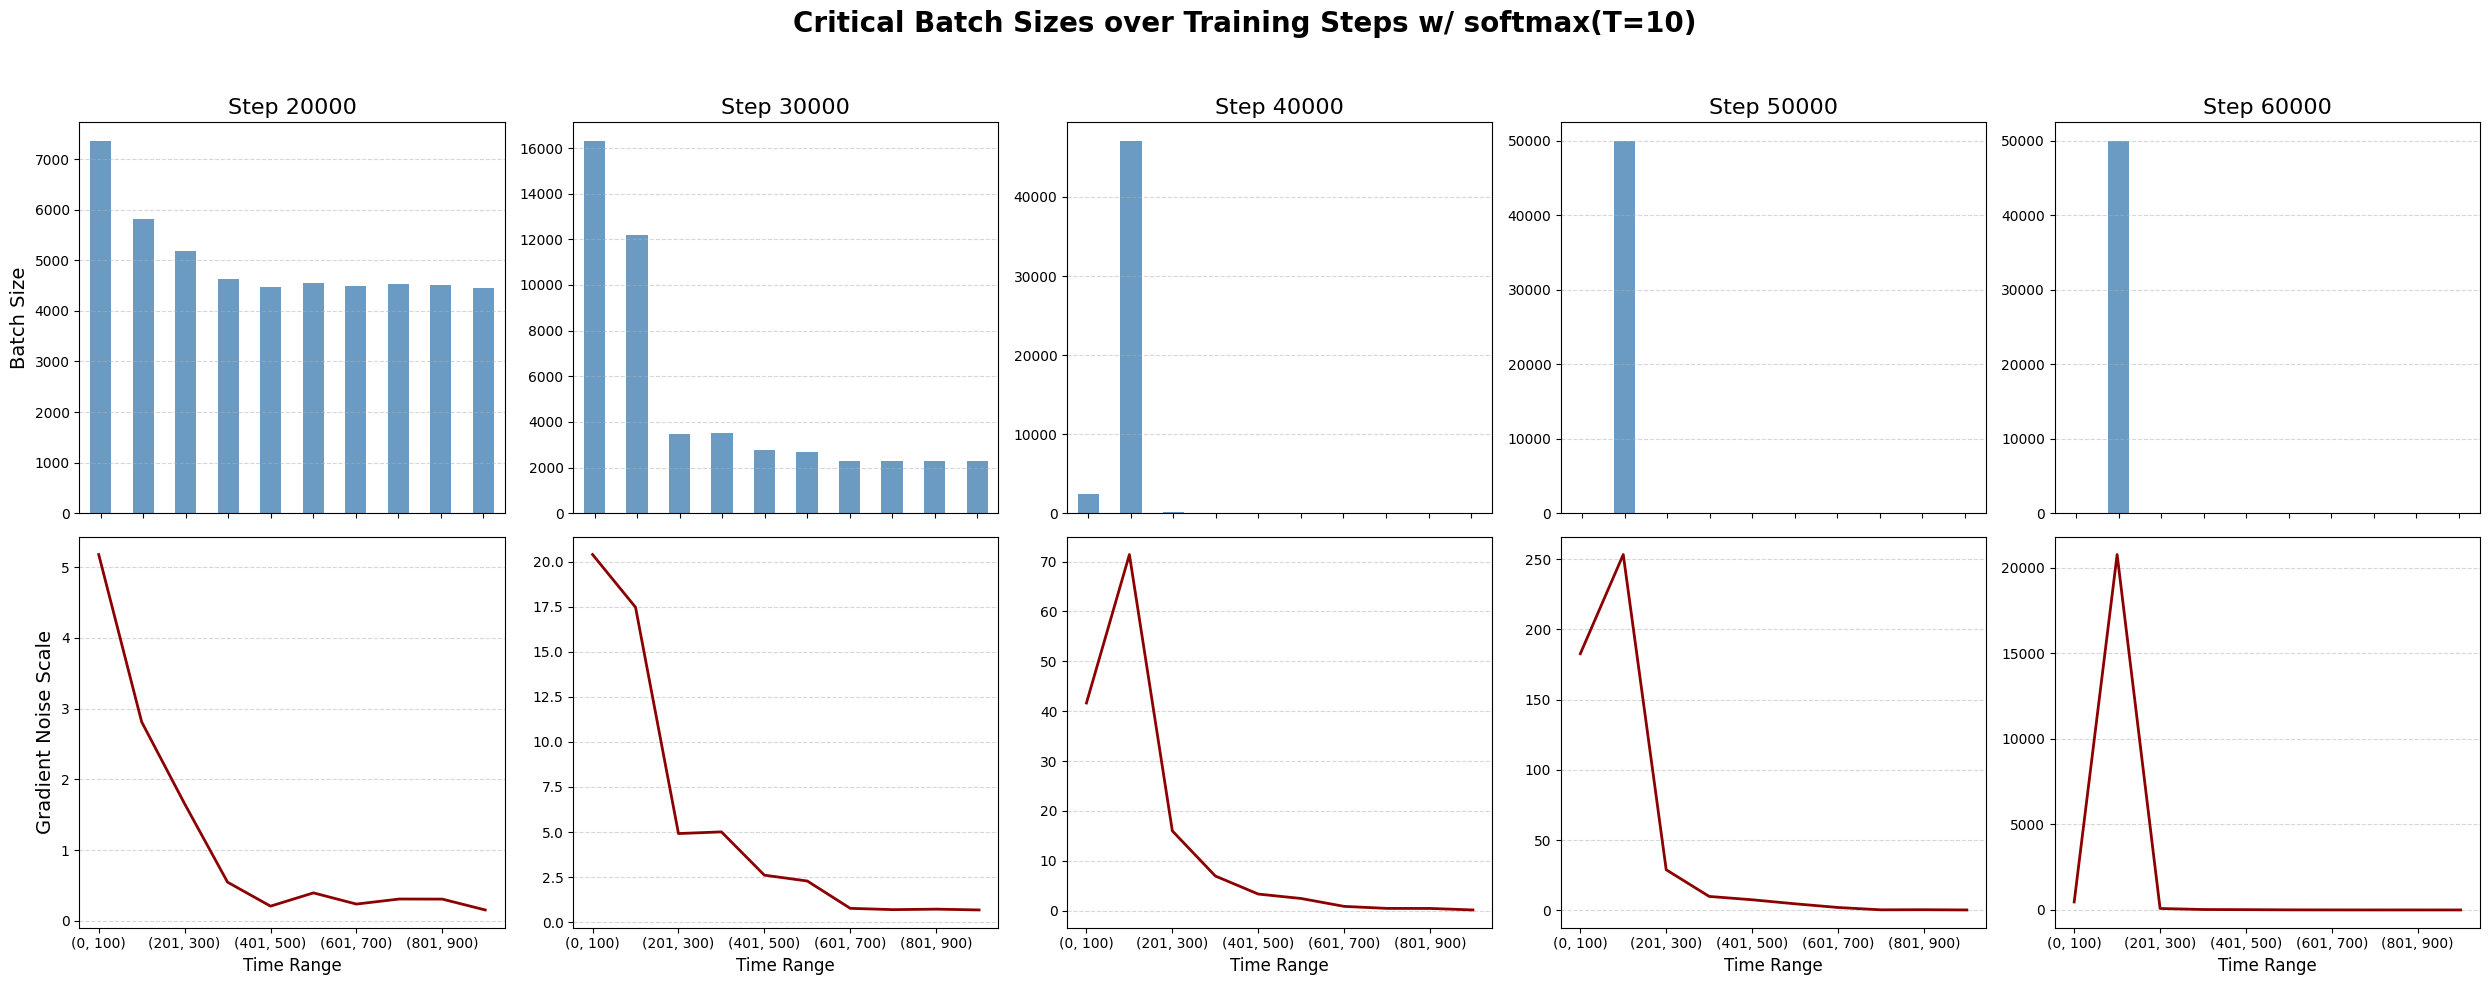

In [12]:
softmax_batches10 = estimate_critical_batch_size_from_time_bins(data, normalize=softmax_normalize, T=10)
title = "Critical Batch Sizes over Training Steps" + f" w/ softmax(T={10})"
save_fig = VIS_DIR / f"critical_batch_sizes_softmax_T{10}_norm.png"
visualize_batches_over_training_steps(softmax_batches10, title=title, save_fig=save_fig)